# Twitter Sentiment Analysis using Spark & Hadoop

### Starting Hadoop Daemons

In [118]:
!start-all.sh

Starting namenodes on [localhost]
Starting datanodes
Starting secondary namenodes [Ahmads-MacBook-Air.local]
2024-04-26 21:15:33,340 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Starting resourcemanager
Starting nodemanagers


### Necessary Libraries

In [169]:
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, lower, expr, udf
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.types import DoubleType, StringType
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer

### Spark Session

In [119]:
spark = SparkSession.builder \
    .appName("HadoopDataFetch") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://127.0.0.1:9000") \
    .getOrCreate()

### Hadoop Cluster to Spark DataFrame

In [190]:
data_path = "/user/ahmadabdullah/twitter/sentiment.csv"

df = spark.read.format("csv").option("header", "true").option("encoding", "utf-8").load(data_path)

df.columns

['id',
 'candidate',
 'candidate_confidence',
 'relevant_yn',
 'relevant_yn_confidence',
 'sentiment',
 'sentiment_confidence',
 'subject_matter',
 'subject_matter_confidence',
 'candidate_gold',
 'name',
 'relevant_yn_gold',
 'retweet_count',
 'sentiment_gold',
 'subject_matter_gold',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_id',
 'tweet_location',
 'user_timezone']

In [191]:
columns_to_keep = ['sentiment', 'sentiment_confidence', 'text']

df = df[columns_to_keep]
df.show(10)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|              0.6578|RT @NancyLeeGrahn...|
| Positive|              0.6333|RT @ScottWalker: ...|
|  Neutral|              0.6629|RT @TJMShow: No m...|
| Positive|                 1.0|RT @RobGeorge: Th...|
| Positive|              0.7045|RT @DanScavino: #...|
| Positive|              0.6332|"RT @GregAbbott_T...|
| Negative|              0.6761|RT @warriorwoman9...|
|  Neutral|                 1.0|Going on #MSNBC L...|
| Negative|              0.6889|Deer in the headl...|
| Negative|              0.6778|RT @NancyOsborne1...|
+---------+--------------------+--------------------+
only showing top 10 rows



In [192]:
df = df.withColumn("sentiment_confidence", df["sentiment_confidence"].cast(DoubleType()))

In [193]:
df.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- sentiment_confidence: double (nullable = true)
 |-- text: string (nullable = true)



In [194]:
df.count()

16032

### Dropping Nulls, Retweets & Duplicate

In [195]:
df = df.na.drop()
df = df.dropDuplicates()

In [196]:
df = df.filter(~df['text'].startswith('RT'))
df = df.filter(~df['text'].startswith('"RT'))

df = df.withColumn('text', expr("regexp_replace(text, '\\b@\\w+\\b', '')"))

df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|              0.3511|@Bipartisanism We...|
| Negative|              0.6841|"After #GOPDebate...|
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|              0.6517|"@Krauthammer: ""...|
| Negative|                 1.0|"""@RubinReport: ...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [197]:

# Define a function to remove words starting with '@'
def remove_at_word(text):
    words = text.split()
    cleaned_words = [word for word in words if not word.startswith('@')]
    return ' '.join(cleaned_words)

# Register the UDF
remove_at_word_udf = udf(remove_at_word, StringType())

# Apply the UDF to the 'text' column
df = df.withColumn('text', remove_at_word_udf(df['text']))

# Show the first 5 rows after updating
df.show(5)


+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|              0.3511|Well, technically...|
| Negative|              0.6841|"After #GOPDebate...|
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|              0.6517|"@Krauthammer: ""...|
| Negative|                 1.0|"""@RubinReport: ...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [198]:
df.count()

6158

### Plotting the Univariate Distribution of Sentiments

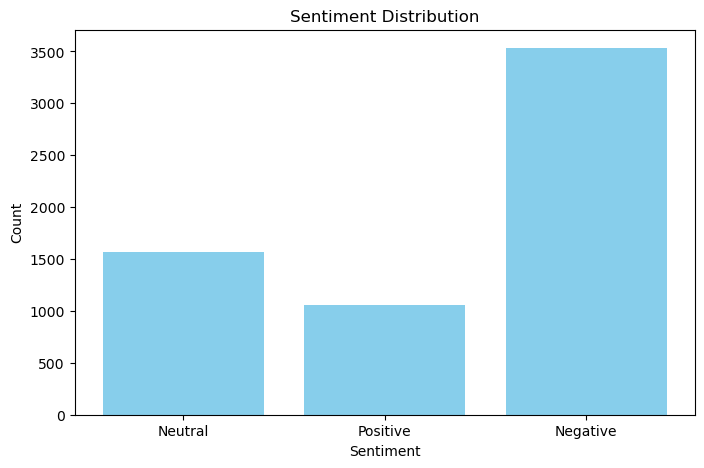

In [199]:
sentiment_counts = df.groupBy('sentiment').count()
sentiment_counts_pd = sentiment_counts.toPandas()
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts_pd['sentiment'], sentiment_counts_pd['count'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

### Text Cleaning

In [200]:
characters = "[^\w\s]"
df = df.withColumn("text", regexp_replace(col("text"), characters, ""))
df = df.withColumn("text", lower(col("text")))

### Tokenization

In [201]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

### StopWord Removal

In [202]:
additional_stop_words = ['gopdebate', 'gopdebates']

stop_words = StopWordsRemover().getStopWords() + additional_stop_words

stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stop_words)
df = stop_words_remover.transform(df)

### Term Frequency

In [203]:
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
tf_df = hashingTF.transform(df)

### Inverse Document Frequency

In [204]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(tf_df)
df = idfModel.transform(tf_df)

In [205]:
df.show(5)

+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|               words|      filtered_words|         rawFeatures|            features|
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Neutral|              0.3511|well technically ...|[well, technicall...|[well, technicall...|(10000,[157,4320,...|(10000,[157,4320,...|
| Negative|              0.6841|after gopdebate t...|[after, gopdebate...|[world, leaders, ...|(10000,[740,3737,...|(10000,[740,3737,...|
|  Neutral|                 1.0|gopdebate constan...|[gopdebate, const...|[constant, alread...|(10000,[533,594,1...|(10000,[533,594,1...|
| Negative|              0.6517|krauthammer the r...|[krauthammer, the...|[krauthammer, rea...|(10000,[2904,4401...|(10000,[2904,4401...|
| Negative|                 1.0|ru

### Word Cloud

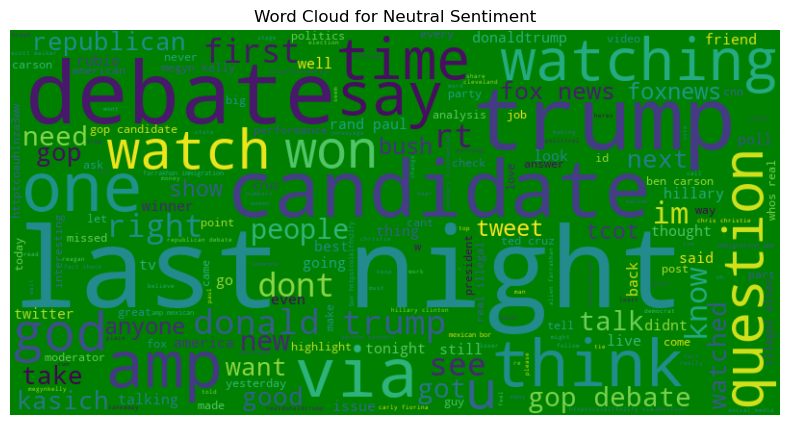

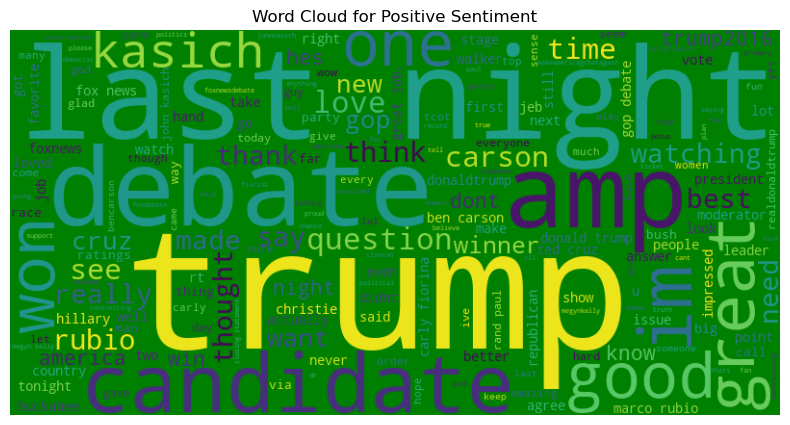

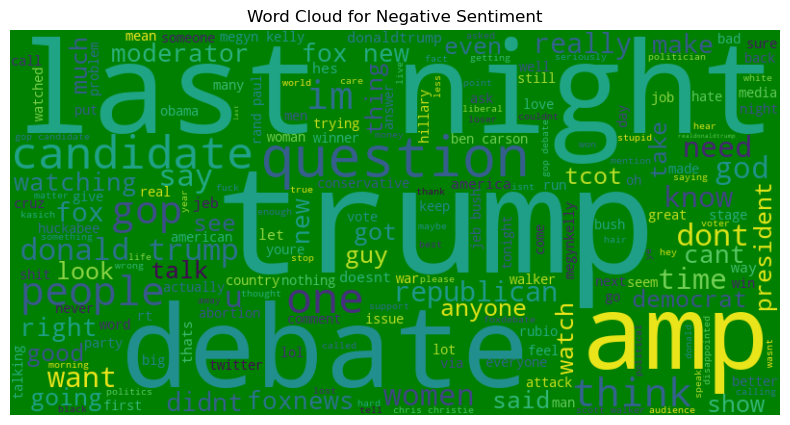

In [207]:
def generate_wordcloud(df, sentiment):
    filtered_text = " ".join(df.filter(df.sentiment == sentiment).rdd.map(lambda x: " ".join(x.filtered_words)).collect())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()

sentiments = df.select("sentiment").distinct().rdd.map(lambda x: x[0]).collect()

for sentiment in sentiments:
    generate_wordcloud(df, sentiment)

In [114]:
spark.stop()

In [115]:
!stop-all.sh

Stopping namenodes on [localhost]
Stopping datanodes
Stopping secondary namenodes [Ahmads-MacBook-Air.local]
2024-04-26 21:13:18,176 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Stopping nodemanagers
Stopping resourcemanager
